# Recomendation system

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from surprise import SVD
from surprise import Dataset
# from scikisurprise.model_selection import cross_validate

In [6]:
pip install scikit-surprise

  Using cached scikit_surprise-1.1.3-cp39-cp39-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\dorot\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [21]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [22]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [23]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
#liczba ocen
ratings.shape[0]

100836

In [25]:
#Liczba użytkowników
ratings["userId"].unique().shape[0]

610

In [26]:
#Średnia liczba ocen na użytkownika
ratings.groupby("userId")["timestamp"].count().mean()

165.30491803278687

In [27]:
#Średni rating na film
mean_rates=pd.DataFrame(ratings.groupby("movieId")["rating"].mean())
mean_rates_tab=pd.merge(movies[["movieId", "title"]], mean_rates, left_on="movieId", right_on="movieId")
mean_rates_tab.head()

,movieId,title,rating
0,1,Toy Story (1995),3.920930
1,2,Jumanji (1995),3.431818
2,3,Grumpier Old Men (1995),3.259615
3,4,Waiting to Exhale (1995),2.357143
4,5,Father of the Bride Part II (1995),3.071429


In [28]:
#Średnia z ocen 
mean_rates_tab['rating'].mean()

3.262448274810963

In [29]:
movies.shape[0]

9742

c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

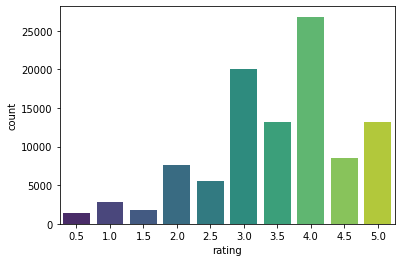

In [30]:
#rozkład ocen
sns.countplot(ratings["rating"], palette="viridis")

In [31]:
movie_titles = dict(zip(movies['movieId'],movies['title']))
movie_titles

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [32]:
movie_stats=ratings.groupby('movieId')['rating'].agg(["count", "mean"])
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [33]:
movie_stats

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.890632
1,2,110,3.431818,3.417227
2,3,52,3.259615,3.260086
3,4,7,2.357143,2.897612
4,5,49,3.071429,3.104793
...,...,...,...,...
9719,193581,1,4.000000,3.327318
9720,193583,1,3.500000,3.283341
9721,193585,1,3.500000,3.283341
9722,193587,1,3.500000,3.283341


In [41]:
#budowanie macierzy
def create_sparse(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [42]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper=create_sparse(ratings)

In [43]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz #scipy.sparse.csr_matrix.nnz no of stored values, including explicit 0
sparsity = n_ratings/n_total
sparsity_p = round(sparsity*100, 2)
print(f"Matrix sparsity: {sparsity_p} %")

Matrix sparsity: 1.7 %


In [44]:
n_ratings_per_user = X.getnnz(axis=1)

In [51]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k=k+1
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [52]:
id_toys=find_similar_movies(1, X, movie_mapper, movie_inv_mapper, 10, metric='cosine')
movies[movies["movieId"].isin(id_toys)]["title"]

224             Star Wars: Episode IV - A New Hope (1977)
314                                   Forrest Gump (1994)
322                                 Lion King, The (1994)
418                                  Jurassic Park (1993)
546                            Mission: Impossible (1996)
615                  Independence Day (a.k.a. ID4) (1996)
911     Star Wars: Episode VI - Return of the Jedi (1983)
964                                  Groundhog Day (1993)
969                             Back to the Future (1985)
2355                                   Toy Story 2 (1999)
Name: title, dtype: object